# Kernel Recursive Least Squares (KRLS) & Kernel Least Mean Squares

Example: Time series prediction

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from kernel import Kernel

from klms import *
from knlms import *
from krls import *
from onlineKernels.klmsRFF import *
from onlineKernels.knlmsRFF import *
from onlineKernels.krlsRFF import *

In [2]:
num_data = 3000

def generate_data(num_data):
    # AWGN
    v = 0.1*np.random.normal(0,1,num_data+2) 

    # Initial conditions
    d_true =[0.1 , 0.1]
    d = [d_true[0] + v[0], d_true[1] + v[1]]

    # Grab new data
    new_d_true = lambda d: d.append((0.8 - 0.5 * np.exp(-(d[-1]**2)))*d[-1] - (0.3 + 0.9*np.exp(-(d[-1]**2)))*d[-2] + 0.1*np.sin(np.pi*d[-1]))
    for i in range(2,num_data+2):
        new_d_true(d_true)
        d.append(d_true[-1] + v[i])

    u = np.hstack((np.array(d[0:num_data]).reshape(num_data,1),np.array(d[1:num_data+1]).reshape(num_data,1)))
    d_true = d_true[2::]
    d = d[2::]
    return np.array(u), np.array(d),np.array(d_true)

In [3]:
kernel = Kernel(3.73)
step_size = 0.09
reg_coeff = 0.1
threshold = 0.5
rls_threshold = 0.6

In [4]:
num_experiments = 25
D = 100
# Experiment
mse_KLMS = np.zeros(num_data)
mse_KNLMS = np.zeros(num_data)
mse_KRLS = np.zeros(num_data)
mse_KLMS_RFF = np.zeros(num_data)
mse_KNLMS_RFF = np.zeros(num_data)
mse_KRLS_RFF = np.zeros(num_data)

KLMS_RFF = klms_rff(step_size,D)
KNLMS_RFF = knlms_rff(step_size,reg_coeff,D)
KRLS_RFF = krls_rff(D)
for i in tqdm(range(num_experiments)):
#     print('experiment',i+1)
    u,d,d_true = generate_data(num_data)
    sigma = 1/np.sqrt(2*kernel.sigma)
    W = (1/sigma) * np.random.normal(size=(2,D))
    b = np.random.uniform(0,2*np.pi,D).reshape(D,1)
    h = np.sqrt(2/D) * np.cos(W.T @ u.T + b)
    
    err_KLMS,_,_ = KLMS(u,d,kernel,step_size,threshold)
    mse_KLMS += (np.square((d_true - d) + err_KLMS))/num_experiments
    
    err_KNLMS,_,_ = KNLMS(u,d,kernel,step_size,reg_coeff,threshold)
    mse_KNLMS += (np.square((d_true - d) + err_KNLMS))/num_experiments
    
    err_KRLS,_,_ = KRLS(u,d,kernel,rls_threshold)
    mse_KRLS += (np.square((d_true - d) + err_KRLS))/num_experiments    

    err_KLMS_RFF,_ = KLMS_RFF.train(h,d,np.zeros((D,1)))
    mse_KLMS_RFF += (np.square((d_true - d) + err_KLMS_RFF))/num_experiments

    err_KNLMS_RFF,_ = KNLMS_RFF.train(h,d,np.zeros((D,1)))
    mse_KNLMS_RFF += (np.square((d_true - d) + err_KNLMS_RFF))/num_experiments    

    err_KRLS_RFF,_ = KRLS_RFF.train(h,d,np.zeros((D,1)))
    mse_KRLS_RFF += (np.square((d_true - d) + err_KRLS_RFF))/num_experiments  

mse_KLMS_smooth = np.convolve(mse_KLMS,np.ones(20)/20,'valid')
mse_KNLMS_smooth = np.convolve(mse_KNLMS,np.ones(20)/20,'valid')
mse_KRLS_smooth = np.convolve(mse_KRLS,np.ones(20)/20,'valid')
mse_KLMS_RFF_smooth = np.convolve(mse_KLMS_RFF,np.ones(20)/20,'valid')
mse_KNLMS_RFF_smooth = np.convolve(mse_KNLMS_RFF,np.ones(20)/20,'valid')
mse_KRLS_RFF_smooth = np.convolve(mse_KRLS_RFF,np.ones(20)/20,'valid')

100%|███████████████████████████████████████████| 25/25 [01:25<00:00,  3.44s/it]


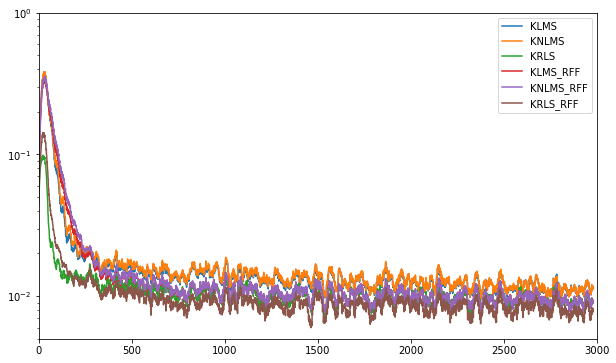

In [5]:
plt.figure(figsize=(10, 6))

plt.semilogy(range(len(mse_KLMS_smooth)),mse_KLMS_smooth, label='KLMS')
plt.semilogy(range(len(mse_KNLMS_smooth)),mse_KNLMS_smooth, label='KNLMS')
plt.semilogy(range(len(mse_KRLS_smooth)),mse_KRLS_smooth, label='KRLS')
plt.semilogy(range(len(mse_KLMS_RFF_smooth)),mse_KLMS_RFF_smooth, label='KLMS_RFF')
plt.semilogy(range(len(mse_KNLMS_RFF_smooth)),mse_KNLMS_RFF_smooth, label='KNLMS_RFF')
plt.semilogy(range(len(mse_KRLS_RFF_smooth)),mse_KRLS_RFF_smooth, label='KRLS_RFF')

plt.ylim([0.005,1e0])
plt.xlim([0,3000])
plt.legend()
plt.show()

# Kernel Approximation using Random Fourier Features
**Require**: A positive definite shift-invariant kernel $k(x, y) = k(x − y)$.

**Ensure**: A randomized feature map $z(\textbf{x}) : \mathbb{R}^d \to \mathbb{R}^D$ so that 
$z(x)'z(y) \approx k(x − y)$

Compute the Fourier transform p of the kernel $k: p(\omega) = \frac{1}{2\pi}\int e^{−j\omega \theta}\delta k(\delta)d\Delta.$

Draw $D$ iid samples $\omega_1, \cdots, \omega_D \in \mathbb{R}^D$

from $p$ and $D$ iid samples $b_1, . . . , b_D \in \mathbb{R}$ from the uniform distribution on $[0,2\pi]$

Let $z(x) ≡\sqrt{\frac{2}{D}}[ cos(\omega_1'\textbf{x}+b_1) ··· cos(\omega_D'\textbf{x}+b_D)]'$

In this case 
$$ p(\omega) = (2\pi)^{-D/2}e^{-\|\omega\|_2^2/2}$$

# Impact of dictionary sizes

In [6]:
num_experiments = 25
# Experiment
kernel = Kernel(3.73)
D = [25,50,100,200]

mse_KLMS_RFF_smooth = []
mse_KNLMS_RFF_smooth = []
mse_KRLS_RFF_smooth = []
for i in range(len(D)):
    mse_KLMS_RFF = np.zeros(num_data)
    mse_KNLMS_RFF = np.zeros(num_data)
    mse_KRLS_RFF = np.zeros(num_data)
    KLMS_RFF = klms_rff(step_size,D[i])
    KNLMS_RFF = knlms_rff(step_size,reg_coeff,D[i])
    KRLS_RFF = krls_rff(D[i])    
    for j in tqdm(range(num_experiments)):
    #     print('experiment',i+1)
        u,d,d_true = generate_data(num_data)
        sigma = 1/np.sqrt(2*kernel.sigma)
        W = (1/sigma) * np.random.normal(loc=0, scale=1.0, size=(2,D[i]))
        b = np.random.uniform(0,2*np.pi,D[i]).reshape(D[i],1)
        h = np.sqrt(2/D[i]) * np.cos(W.T @ u.T + b)

        err_KLMS_RFF,_ = KLMS_RFF.train(h,d,np.zeros((D[i],1)))
        mse_KLMS_RFF += (np.square((d_true - d) + err_KLMS_RFF))/num_experiments

        err_KNLMS_RFF,_ = KNLMS_RFF.train(h,d,np.zeros((D[i],1)))
        mse_KNLMS_RFF += (np.square((d_true - d) + err_KNLMS_RFF))/num_experiments    

        err_KRLS_RFF,_ = KRLS_RFF.train(h,d,np.zeros((D[i],1)))
        mse_KRLS_RFF += (np.square((d_true - d) + err_KRLS_RFF))/num_experiments     

    mse_KLMS_RFF_smooth.append(np.convolve(mse_KLMS_RFF,np.ones(20)/20,'valid'))
    mse_KNLMS_RFF_smooth.append(np.convolve(mse_KNLMS_RFF,np.ones(20)/20,'valid'))
    mse_KRLS_RFF_smooth.append(np.convolve(mse_KRLS_RFF,np.ones(20)/20,'valid'))

100%|███████████████████████████████████████████| 25/25 [00:14<00:00,  1.69it/s]


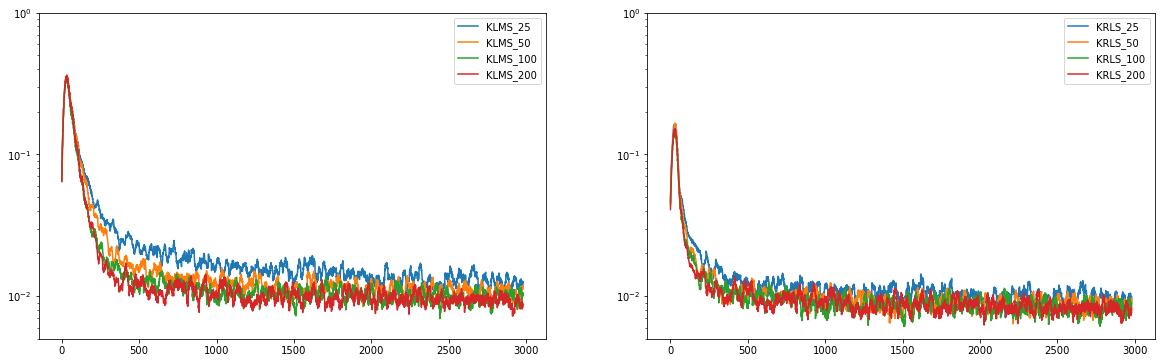

In [7]:
plt.figure(figsize=(2*10, 6))

plt.subplot(1, 2, 1)
for i in range(len(D)):
    plt.semilogy(range(len(mse_KLMS_RFF_smooth[i])),mse_KLMS_RFF_smooth[i], label='KLMS_' + str(D[i]))
plt.legend()
plt.ylim([0.005,1e0])
plt.subplot(1, 2, 2)
for i in range(len(D)):
    plt.semilogy(range(len(mse_KRLS_RFF_smooth[i])),mse_KRLS_RFF_smooth[i], label='KRLS_' + str(D[i]))
plt.legend()
plt.ylim([0.005,1e0])
# plt.xlim([0,3000])

plt.show()

# Impact of Gaussian widths
dictionary size of 25

In [17]:
num_experiments = 25
# Experiment
sigmas = [1.15,2.25,3.73]

D = 100

mse_KLMS_smooth = []
mse_KNLMS_smooth = []
mse_KRLS_smooth = []
mse_KLMS_RFF_smooth = []
mse_KNLMS_RFF_smooth = []
mse_KRLS_RFF_smooth = []

KLMS_RFF = klms_rff(h,step_size,D)
KNLMS_RFF = knlms_rff(h,step_size,reg_coeff,D)
KRLS_RFF = krls_rff(h,D)
for s in range(len(sigmas)):
    
    kernel = Kernel(sigmas[s])
    
    mse_KLMS = np.zeros(num_data)
    mse_KRLS = np.zeros(num_data)    
    mse_KLMS_RFF = np.zeros(num_data)
    mse_KRLS_RFF = np.zeros(num_data)
    
    for j in tqdm(range(num_experiments)):
    #     print('experiment',i+1)
        u,d,d_true = generate_data(num_data)
        
        sigma = 1/np.sqrt(2*kernel.sigma)
        W = (1/sigma) * np.random.normal(loc=0, scale=1.0, size=(2,D))
        b = np.random.uniform(0,2*np.pi,D).reshape(D,1)
        h = np.sqrt(2/D) * np.cos(W.T @ u.T + b)

        err_KLMS,_,_ = KLMS(u,d,kernel,step_size,0.5)
        mse_KLMS += (np.square((d_true - d) + err_KLMS))/num_experiments

        err_KNLMS,_,_ = KNLMS(u,d,kernel,step_size,reg_coeff,0.5)
        mse_KNLMS += (np.square((d_true - d) + err_KNLMS))/num_experiments

        err_KRLS,_,_ = KRLS(u,d,kernel,0.5)
        mse_KRLS += (np.square((d_true - d) + err_KRLS))/num_experiments    

        err_KLMS_RFF,_ = KLMS_RFF(u,d,h,step_size,D,alpha_0=np.zeros((D,1)))
        mse_KLMS_RFF += (np.square((d_true - d) + err_KLMS_RFF))/num_experiments

        err_KNLMS_RFF,_ = KNLMS_RFF(u,d,h,step_size,reg_coeff,D,alpha_0=np.zeros((D,1)))
        mse_KNLMS_RFF += (np.square((d_true - d) + err_KNLMS_RFF))/num_experiments    

        err_KRLS_RFF,_ = KRLS_RFF(u,d,h,D,alpha_0=np.zeros((D,1)))
        mse_KRLS_RFF += (np.square((d_true - d) + err_KRLS_RFF))/num_experiments    
        
    mse_KLMS_smooth.append(np.convolve(mse_KLMS,np.ones(20)/20,'valid'))
    mse_KNLMS_smooth.append(np.convolve(mse_KNLMS,np.ones(20)/20,'valid'))
    mse_KRLS_smooth.append(np.convolve(mse_KRLS,np.ones(20)/20,'valid'))
    mse_KLMS_RFF_smooth.append(np.convolve(mse_KLMS_RFF,np.ones(20)/20,'valid'))
    mse_KNLMS_RFF_smooth.append(np.convolve(mse_KNLMS_RFF,np.ones(20)/20,'valid'))    
    mse_KRLS_RFF_smooth.append(np.convolve(mse_KRLS_RFF,np.ones(20)/20,'valid'))

100%|███████████████████████████████████████████| 25/25 [01:29<00:00,  3.57s/it]


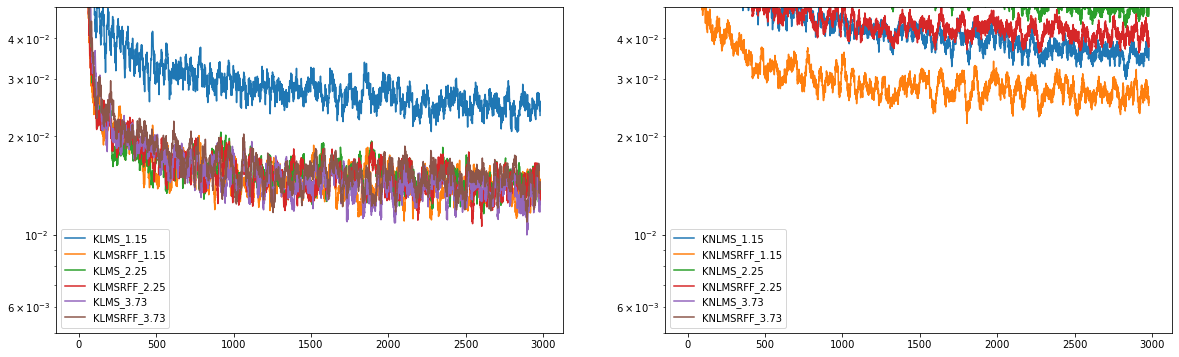

In [18]:
plt.figure(figsize=(2*10, 6))
plt.subplot(1, 2, 1)
for s in range(len(sigmas)):
    plt.semilogy(range(len(mse_KLMS_smooth[s])),mse_KLMS_smooth[s], label='KLMS_' + str(sigmas[s]))  
    plt.semilogy(range(len(mse_KLMS_RFF_smooth[s])),mse_KLMS_RFF_smooth[s], label='KLMSRFF_' + str(sigmas[s]))
plt.legend()
plt.ylim([0.005,5e-2])
plt.subplot(1, 2, 2)
for s in range(len(sigmas)):
    plt.semilogy(range(len(mse_KNLMS_smooth[s])),mse_KNLMS_smooth[s], label='KNLMS_' + str(sigmas[s]))  
    plt.semilogy(range(len(mse_KNLMS_RFF_smooth[s])),mse_KNLMS_RFF_smooth[s], label='KNLMSRFF_' + str(sigmas[s]))    
plt.legend()
plt.ylim([0.005,5e-2])
# plt.xlim([0,3000])

plt.show()

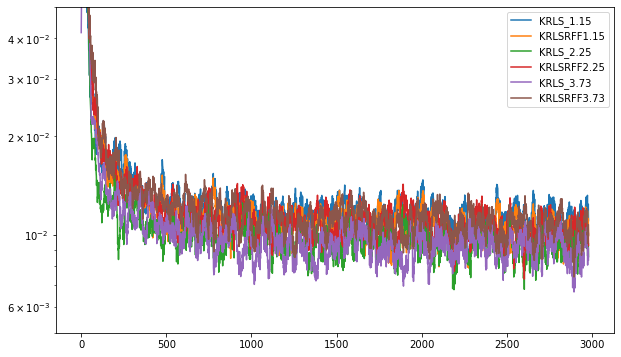

In [20]:
plt.figure(figsize=(10, 6))
for s in range(len(sigmas)):
    plt.semilogy(range(len(mse_KRLS_smooth[s])),mse_KRLS_smooth[s], label='KRLS_' + str(sigmas[s]))
    plt.semilogy(range(len(mse_KRLS_RFF_smooth[s])),mse_KRLS_RFF_smooth[s], label='KRLSRFF' + str(sigmas[s]))
plt.legend()
plt.ylim([0.005,5e-2])

plt.show()